#**Generative Adversarial Networks (Gans) per la Generazione di Dati Sintetici Tabellari (Relazionali)**

In [ ]:
import os

#**Installazione delle Librerie Necessarie**

In [ ]:
os.system('pip install --upgrade --no-cache-dir gdown')
os.system('pip install table_evaluator')
os.system('pip install italian_holidays')

0

#**Tutti Gli Import**

In [ ]:
import timeit
import platform
import numpy as np
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
from numpy.random import randn
from matplotlib import pyplot

#**Tutti gli Import di Machine Learning: Tensorflow 2.x (Keras) e Scikit-Learn** 

In [ ]:
from table_evaluator import TableEvaluator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.models import load_model
# from keras.layers import Reshape
# from keras.layers import Flatten
# from keras.layers import Conv2D
# from keras.layers import Conv2DTranspose
# from keras.layers import LeakyReLU
# from keras.layers import BatchNormalization
# from keras.initializers import RandomNormal
# from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#**Inizializzazioni**

In [ ]:
OS = platform.system()   # Sistema Operativo    

# **Tutte le variabili Globali**

In [ ]:
dataset = 'diabetes'
training = True

#**Iper-parametri**

In [ ]:
if dataset is 'diabetes':
  latent_dim = 10           # dimensione dello spazio latente
  epochs = 10000            # numero delle iterazioni

<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-11-3c9e67718e14>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dataset is 'diabetes':


#**Tutte le Definizioni di Funzioni Generali**

##**Funzione di Esplorazione dei Dati con Pandas**

In [ ]:
def explore_data(data): 
  print("\nForma dei Dati: ", data.shape)
  print("\nInformazioni sui Dati: \n")
  try: 
    data.info()
  except: 
    pass
  print("\nLoop su ciascuna colonna alla ricerca di valori nulli: \n")
  try: 
    for i in range(len(data.columns)):
        print(data.columns[i] + ": " + str(data[data.columns[i]].isna().sum()))
  except: 
    pass

##**Funzione di scarico dei dati con GDown**

In [ ]:
def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None    

##**Funzione di Creazione del Line Plot della Loss per la GAN**

In [ ]:
def plot_history(d_hist, g_hist):
	# plot loss
	plt.subplot(1, 1, 1)
	plt.plot(d_hist, label='Discriminator')
	plt.plot(g_hist, label='Generator')
	plt.legend()
	# plot discriminator accuracy
	# pyplot.subplot(2, 1, 2)
	# pyplot.plot(a1_hist, label='acc-real')
	# pyplot.plot(a2_hist, label='acc-fake')
	plt.show()
	# save plot to file
	# plt.savefig('results_baseline/plot_line_plot_loss.png')
	plt.close()

##**Generazione dei Punti nello spazio latente come input del Generatore della GAN**

In [ ]:
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)             	      # generazione dei punti nello spazio latente
  x_input = x_input.reshape(n_samples, latent_dim)            # reshape dei dati dentro un batch di input per la rete
	
  return x_input

##**Uso del Generatore per generare n esempi di fake, con le label di classe**


In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)     # generazione dei punti nello spazio latente
	X = generator.predict(x_input)                              # predice gli output
	y = np.zeros((n_samples, 1))                                # crea le label di classe false (fake)

	return X, y

##**Genera n esempi reali con le label di classe**

In [ ]:
def generate_real_samples(n):
  X = data.sample(n)

  y = np.ones((n, 1))                                         # genera le label di classe
  return X, y

#**Definizione del Modello di Deep Learning: GAN**

##**Definizione del Modello Generatore**

In [ ]:
def define_generator(latent_dim, n_outputs=9):
  model = Sequential()

  if dataset is 'diabetes': 
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(30, activation='relu'))
  
  # model.add(Dense(n_outputs, activation='sigmoid'))
  model.add(Dense(n_outputs, activation='linear'))
  model.summary()

  return model

<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-18-cd8a6f9f4d70>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dataset is 'diabetes':


##**Definizione del Modello Discriminatore** 

In [ ]:
def define_discriminator(n_inputs=9):
  model = Sequential()
  # model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer='he_uniform', input_shape=n_inputs))
  # model.add(BatchNormalization())
  # model.add(LeakyReLU(alpha=0.2))
  # model.add(Dense(25, activation='relu'))
  
  if dataset is 'diabetes': 
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(50, activation='relu'))
    
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()

  return model

<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-19-fcc305279729>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dataset is 'diabetes':


##**Definizione del Modello GAN combinando generatore e discriminatore insieme**


In [ ]:
def define_gan(generator, discriminator):
	
	discriminator.trainable = False                     # rende i pesi del discriminatore non addestrabili
	model = Sequential()                                # connessione di generatore e discriminatore insieme
	model.add(generator)    										        # aggiunge il generatore
	model.add(discriminator)    												# aggiunge il discriminatore

	model.compile(loss='binary_crossentropy', optimizer='adam')
	
	model.layers[0]._name = "Generator"
	model.layers[1]._name = "Discriminator"
	
	model.summary()
	return model

##**Training della GAN**

In [ ]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
  
  half_batch = int(n_batch / 2)                                                   # determina metà della dimensione di un batch, per aggiornare il discriminatore

  d_history = []
  g_history = []
  
  for epoch in range(n_epochs):
    x_real, y_real = generate_real_samples(half_batch)                            # preparazione degli esempi reali 
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)       # preparazione degli esempi fake
 
    # aggiornamento del discriminatore
    d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
    d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)                               # calcolo della loss del discriminatore
    
    x_gan = generate_latent_points(latent_dim, n_batch)                           # preparazione dei punti nello spazio latente come input del generatore
    
    y_gan = np.ones((n_batch, 1))                                                 # creazione delle etichette invertite per gli esempi fake
    
    g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)                          # aggiornamento del generatore attraverso l'errore del discriminatore

    print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
    d_history.append(d_loss)
    g_history.append(g_loss_fake)

  plot_history(d_history, g_history)

    # if i==999:
    #   np.savetxt("new_X.csv", X, delimiter=",")
    
    # if (i+1) % n_eval == 0:
    #   summarize_performance(i, g_model, d_model, latent_dim)
  g_model.save(dataset+'_trained_gan_model.h5')

##**Valutazione del discriminatore e plottaggio dei punti reali e fake**

In [ ]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	x_real, y_real = generate_real_samples(n)                                     # preparazione degli esempi reali 
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)               # valutazione del discriminatore su esempi reali

	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)              # preparazione degli esempi di fake
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)               # valutazione del discriminatore su esempi di fake

	# riassume le performance del discriminatore
	print(epoch, acc_real, acc_fake)
  # scatter plot dei punti reali e fake
	pyplot.scatter(x_real[:, 0], color='red')
	pyplot.scatter(x_fake[:, 0], color='blue')
	pyplot.show()

# **Scarico dei Dataset di Benchmark e di Produzione - ACS, SatGPA, Telefonia**

In [ ]:
start_time = timeit.default_timer()
if dataset is 'diabetes':
  out = data_download("./diabetes.zip", "1y-JNu2gHldlhhLfBD17mVj4wP69jx2ks", OS)
  data = pd.read_csv('./diabetes.csv')
  data['Outcome'] = data['Outcome'].astype("object")                                          # serve per fare statistiche descrittive diverse tra dati nuerici e dati categorici
  n_to_generate = len(data)
  columns_names = list(data.columns)
  features = columns_names[0:-1]
  label = columns_names[-1]

print("Elapsed Time: ", timeit.default_timer() - start_time)

<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-23-9b536a5c1224>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dataset is 'diabetes':


Elapsed Time:  1.7285619520000068


#**EDA dei Dati Reali - Exploratory Data Analysis**

In [ ]:
explore_data(data)


Forma dei Dati:  (768, 9)

Informazioni sui Dati: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 54.1+ KB

Loop su ciascuna colonna alla ricerca di valori nulli: 

Pregnancies: 0
Glucose: 0
BloodPressure: 0
SkinThickness: 0
Insulin: 0
BMI: 0
DiabetesPedigreeFunction: 0
Age: 0
Outc

In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                      object
dtype: object

In [ ]:
data.describe(include = [np.number]).T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


In [ ]:
if dataset is 'diabetes':
  data.describe(include = ['O']).T

<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-28-1a1626500856>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dataset is 'diabetes':


#**Sanity Check dei dati con Algoritmo di Machine Learning: Random Forest**

In [ ]:
if dataset is 'diabetes':
  data['Outcome'] = data['Outcome'].astype("int64")
  
  data.Outcome.unique()

  X = data[features]
  y = data[label]

  X_true_train, X_true_test, y_true_train, y_true_test = train_test_split(X, y, test_size=0.30, random_state=42)
  clf_true = RandomForestClassifier(n_estimators=100)
  clf_true.fit(X_true_train,y_true_train)

  y_true_pred=clf_true.predict(X_true_test)
  
  print("\nAccuratezza del Modello di Classificazione Random Forest sui Dati Reali: ",metrics.accuracy_score(y_true_test, y_true_pred))
  print("\nReport di Classificazione sul Random Forest sui Dati Reali: ",metrics.classification_report(y_true_test, y_true_pred))

<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-29-3f2f39884257>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dataset is 'diabetes':



Accuratezza del Modello di Classificazione Random Forest sui Dati Reali:  0.7359307359307359

Report di Classificazione sul Random Forest sui Dati Reali:                precision    recall  f1-score   support

           0       0.81      0.78      0.79       151
           1       0.61      0.65      0.63        80

    accuracy                           0.74       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.74      0.74       231



#**Definizione del Modello GAN**

In [ ]:
print("Generatore: \n")
generator = define_generator(latent_dim, data.shape[1])
print("\n\nDiscriminatore: \n")
discriminator = define_discriminator(data.shape[1])
print("\n\nGenerative Adversarial Network: \n")
gan_model = define_gan(generator, discriminator)

Generatore: 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                165       
                                                                 
 dense_1 (Dense)             (None, 30)                480       
                                                                 
 dense_2 (Dense)             (None, 9)                 279       
                                                                 
Total params: 924
Trainable params: 924
Non-trainable params: 0
_________________________________________________________________


Discriminatore: 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                250       
                                                                 
 d

#**Training Del Modello GAN**

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 9ms/step
>7501, d1=0.429, d2=0.223 d=0.326 g=2.104
2/2 [==============================] - 0s 3ms/step
>7502, d1=0.490, d2=0.324 d=0.407 g=1.954
2/2 [==============================] - 0s 3ms/step
>7503, d1=0.528, d2=0.317 d=0.423 g=1.770
2/2 [==============================] - 0s 9ms/step
>7504, d1=0.655, d2=0.352 d=0.504 g=1.631
2/2 [==============================] - 0s 3ms/step
>7505, d1=0.424, d2=0.364 d=0.394 g=1.586
2/2 [==============================] - 0s 5ms/step
>7506, d1=0.498, d2=0.351 d=0.425 g=1.850
2/2 [==============================] - 0s 3ms/step
>7507, d1=0.443, d2=0.251 d=0.347 g=2.097
2/2 [==============================] - 0s 6ms/step
>7508, d1=0.484, d2=0.229 d=0.357 g=2.046
2/2 [==============================] - 0s 8ms/step
>7509, d1=0.466, d2=0.265 d=0.366 g=1.905
2/2 [==============================] - 0s 5ms/step
>7510, d1=0.405, d2=0.298 d=0.351 g=1.756
2/2 [==============

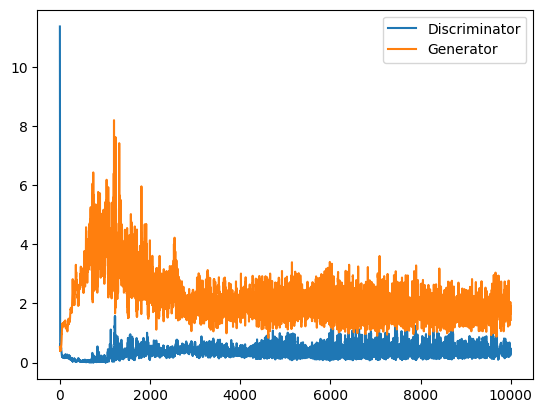



Elapsed Training Time:  1151.493676481


In [ ]:
if training is True: 
  start_train_time = timeit.default_timer()
  train(generator, discriminator, gan_model, latent_dim, n_epochs = epochs)
  print("\n\nElapsed Training Time: ", timeit.default_timer() - start_train_time)

#**Generazione dei Dati Sintetici**

In [ ]:
model = load_model('./'+dataset+'_trained_gan_model.h5')
latent_points = generate_latent_points(latent_dim, n_to_generate)
X = model.predict(latent_points)
synth_data = pd.DataFrame(data=X,  columns = columns_names)

24/24 [==============================] - 0s 1ms/step


#**EDA dei Dati Sintetici - Exploratory Data Analysis**

In [ ]:
explore_data(synth_data)


Forma dei Dati:  (768, 9)

Informazioni sui Dati: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float32
 1   Glucose                   768 non-null    float32
 2   BloodPressure             768 non-null    float32
 3   SkinThickness             768 non-null    float32
 4   Insulin                   768 non-null    float32
 5   BMI                       768 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    float32
 8   Outcome                   768 non-null    float32
dtypes: float32(9)
memory usage: 27.1 KB

Loop su ciascuna colonna alla ricerca di valori nulli: 

Pregnancies: 0
Glucose: 0
BloodPressure: 0
SkinThickness: 0
Insulin: 0
BMI: 0
DiabetesPedigreeFunction: 0
Age: 0
Outcome: 0


In [ ]:
synth_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,10.2224,211.6144,122.9794,-1.3513,1.7173,65.4483,-0.7830,49.6006,2.6149
1,9.7932,83.8012,86.8238,11.0495,0.5342,17.6313,-0.6432,71.6757,-0.1590
2,0.8836,63.7760,32.4304,-1.0393,0.2451,12.8672,0.0361,12.2503,0.4139
3,2.5998,128.5043,107.9591,58.3652,-0.0387,48.8928,-0.8354,37.1596,0.8443
4,4.6787,163.6113,108.5259,-0.2313,1.3264,51.2106,-1.1417,40.3401,2.1688


In [ ]:
synth_data.dtypes

Pregnancies                 float32
Glucose                     float32
BloodPressure               float32
SkinThickness               float32
Insulin                     float32
BMI                         float32
DiabetesPedigreeFunction    float32
Age                         float32
Outcome                     float32
dtype: object

In [ ]:
#synth_data = synth_data.astype("int64")

In [ ]:
if dataset is "diabetes":
  synth_data['Outcome'] = synth_data['Outcome'] > synth_data.Outcome.mean()
  synth_data["Outcome"] = synth_data["Outcome"].astype(int)

  X_synth = synth_data[features]
  y_synth = synth_data[label]

  X_synth_train, X_synth_test, y_synth_train, y_synth_test = train_test_split(X_synth, y_synth, test_size=0.30, random_state=42)
  clf_synth = RandomForestClassifier(n_estimators=100)
  clf_synth.fit(X_synth_train, y_synth_train)

  y_synth_pred=clf_synth.predict(X_synth_test)
  print("Accuratezza del Modello di Classificazione Random Forest sui Dati Sintetici: ",metrics.accuracy_score(y_synth_test, y_synth_pred))
  print("Report di Classificazione sul Random Forest sui Dati Sintetici: ",metrics.classification_report(y_synth_test, y_synth_pred))

  table_evaluator = TableEvaluator(data, synth_data)
  table_evaluator.evaluate(target_col='Outcome')
  table_evaluator.visual_evaluation()
elif dataset is 'telephony':
  table_evaluator = TableEvaluator(data, synth_data)
  #table_evaluator.evaluate(target_col='COD_CELLA_CHIAMATA')
  table_evaluator.visual_evaluation(save_dir = './')  